In [65]:
import numpy as np
import glob
import xarray as xr
import netCDF4

import matplotlib.pyplot as plt
from matplotlib import rcParams

# CPOL convenience functions
import CPOL_func as cf

In [66]:
# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
test_wind = xr.open_dataset('/g/data/w40/esh563/lind04_2500_winds/2006-02-09T10:20:00.nc')

In [161]:
test = xr.open_dataset('/g/data/w40/esh563/lind04/dbz/2006-02-09_10:40:00alllevels_zlib.nc')

In [162]:
test['y'] = test.longitude[0,0,0,:].squeeze().values
test['x'] = test.latitude[0,0,:,0].squeeze().values

In [7]:
test = test.sel(x = -13, method='nearest')
test = test.isel(time=0)

In [40]:
test_wind = test_wind.sel(lat = -13, method='nearest')

In [123]:
test_wind = test_wind.sel(lon=slice(130.5, 132))

In [124]:
test_wind = test_wind.sel(alt=3000)

ValueError: dimensions or multi-index levels ['alt'] do not exist

ValueError: Either colors or cmap must be None

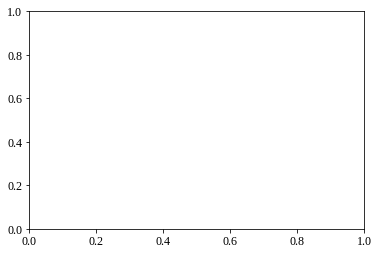

In [134]:
plt.contour(test_wind.lon, test_wind.lat, test_wind.W, levels=[2], colors='k',)

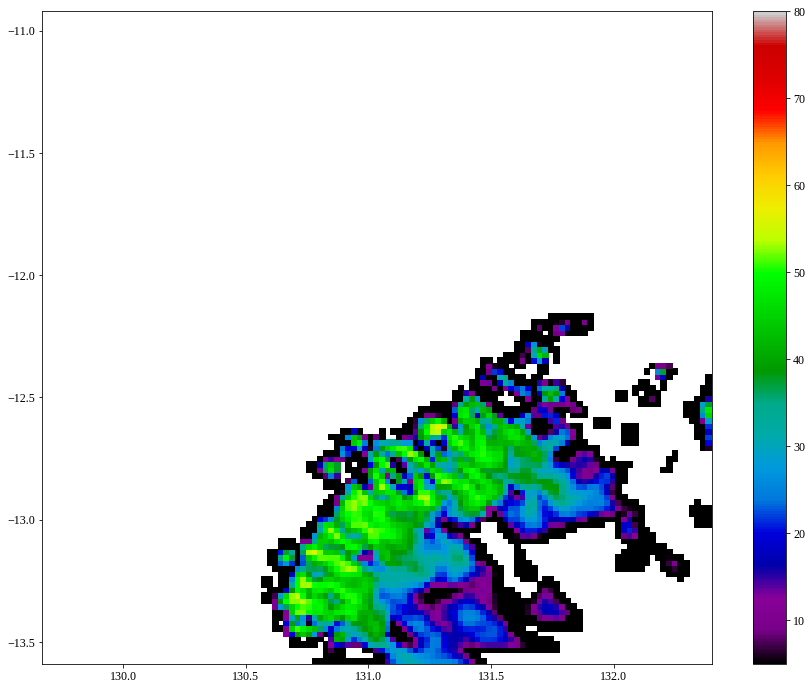

In [165]:
fig = plt.figure(figsize=(15, 12))
# test = test.sel(z=3000)
# test = test.isel(time=0)
plt.pcolormesh(test.y, test.x, test.reflectivity, vmin=5, vmax=80,  cmap='nipy_spectral')
plt.colorbar()
# plt.contour(test_wind.lon, test_wind.lat, test_wind.W, levels=[2], colors='k')
# test


In [ ]:
fig = plt.figure(figsize=(15, 12))
plt.contourf(test.y, test.x, test.reflectivity)


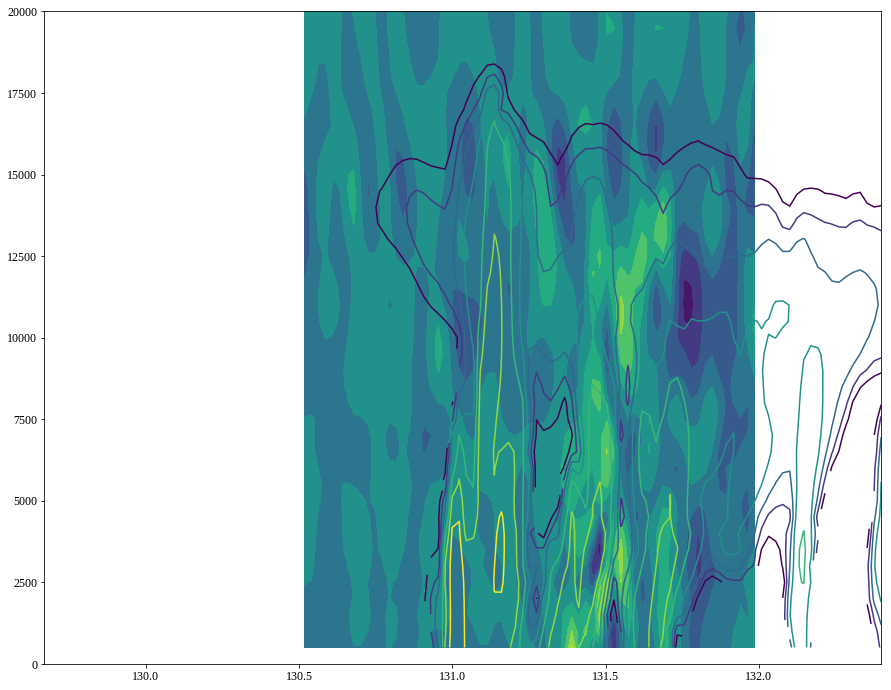

In [57]:
fig = plt.figure(figsize=(15, 12))
plt.contour(test.y, test.z, test.reflectivity)
plt.contourf(test_wind.lon, test_wind.alt, test_wind.W, linewidths=0.75)

In [147]:
test2 = xr.open_dataset('/g/data/w40/esh563/d04.dir/wrfout_d04_2006-02-09_10:00:00.nc.gz')

In [148]:
XLAT = test2.XLAT.values[0,:,0]
XLONG = test2.XLONG.values[0,0,:]
XLAT_S = test2.XLAT_V.values[0,:,0]
XLONG_S = test2.XLONG_U.values[0,0,:]

In [157]:
test2['south_north']=XLAT
test2['west_east']=XLONG
test2['south_north_stag']=XLAT_S
test2['west_east_stag']=XLONG_S

hgt_AGL = np.load('/g/data/w40/esh563/d04_hgt_AGL.npy')

# Create function to de
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

test2['bottom_top']=moving_average(hgt_AGL, n=2)
test2['bottom_top_stag'] = hgt_AGL

In [158]:
test2_sub = test2.sel(south_north=slice(-13.8, -10.8))
test2_sub = test2_sub.sel(south_north_stag=slice(-13.8, -10.8))
test2_sub = test2_sub.sel(west_east_stag=slice(130.5, 132))
test2_sub = test2_sub.sel(west_east=slice(130.5, 132))
test2_sub = test2_sub.sel(bottom_top=3000, method='nearest')
test2_sub = test2_sub.sel(bottom_top_stag=3000, method='nearest')

In [167]:
test_sub = test.sel(y=slice(130.5, 132))

In [160]:
W = test2_sub.W.isel(Time = 2)
QCLOUD = test2_sub.QCLOUD.isel(Time = 2)
QRAIN = test2_sub.QRAIN.isel(Time = 2)
QICE = test2_sub.QICE.isel(Time = 2)
QSNOW = test2_sub.QSNOW.isel(Time = 2)
QGRAUP = test2_sub.QGRAUP.isel(Time = 2)

In [153]:
W = test2_sub.W.sel(south_north = -13, method='nearest').isel(Time = 2)
QCLOUD = test2_sub.QCLOUD.sel(south_north = -13, method='nearest').isel(Time = 2)
QRAIN = test2_sub.QRAIN.sel(south_north = -13, method='nearest').isel(Time = 2)
QICE = test2_sub.QICE.sel(south_north = -13, method='nearest').isel(Time = 2)
QSNOW = test2_sub.QSNOW.sel(south_north = -13, method='nearest').isel(Time = 2)
QGRAUP = test2_sub.QGRAUP.sel(south_north = -13, method='nearest').isel(Time = 2)

AttributeError: Unknown property colors

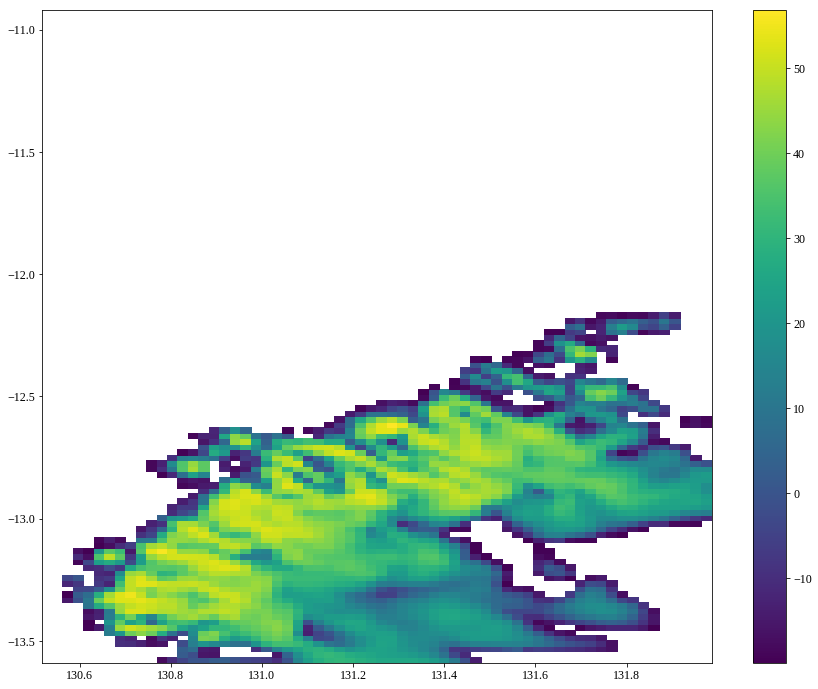

In [172]:
# Initialise fonts
rcParams.update({'font.family' : 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset' : 'dejavuserif'})
rcParams.update({'font.size': 12})    

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1,)
# plt.contourf(W.west_east.values, W.bottom_top_stag.values, W, levels=np.arange(-16,18,2), cmap='RdBu_r')
# cbar = plt.colorbar()
# cbar.set_label('Vertical Velocity [m/s]')

cnt0 = ax.pcolor(test_sub.y, test_sub.x, test_sub.reflectivity)
cbar = plt.colorbar(cnt0)

# cnt1 = ax.contour(W.west_east.values, QCLOUD.bottom_top, QCLOUD, 
#                   colors='k', levels=[0.0001], linewidths=0.75)
# cnt2 = ax.contour(W.west_east.values, QCLOUD.bottom_top, QRAIN, 
#                   colors='b',  levels=[0.0001], linewidths=0.75)
# cnt3 = ax.contour(W.west_east.values, QICE.bottom_top, QICE, 
#                   colors='r',levels=[0.0001], linewidths=0.75)
# cnt3 = ax.contour(W.west_east.values, QSNOW.bottom_top, QSNOW, 
#                   colors='m',levels=[0.0001], linewidths=0.75)
# cnt3 = ax.contour(W.west_east.values, QGRAUP.bottom_top, QGRAUP, 
#                   colors='m',levels=[0.0001], linewidths=0.75)

# cnt1 = ax.contour(QCLOUD.west_east.values, QCLOUD.south_north.values, QCLOUD, 
#                   colors='k', linewidths=0.75)
cnt2 = ax.pcolor(W.west_east.values, QCLOUD.south_north, QRAIN, 
                  colors='b', linewidths=0.75)
# cnt2 = ax.pcolor(W.west_east.values, QCLOUD.south_north, QRAIN)
# cnt3 = ax.contour(W.west_east.values, QICE.bottom_top, QICE, 
#                   colors='r', linewidths=0.75)
# cnt4 = ax.contour(W.west_east.values, QSNOW.bottom_top, QSNOW, 
#                   colors='m', linewidths=0.75)
# cnt5 = ax.contour(W.west_east.values, QGRAUP.bottom_top, QGRAUP, 
#                   colors='g', linewidths=0.75)

h1,_ = cnt1.legend_elements()
# h2,_ = cnt2.legend_elements()
h3,_ = cnt3.legend_elements()
h4,_ = cnt4.legend_elements()
h5,_ = cnt5.legend_elements()

plt.xlabel('Longitude [Degrees East]')
plt.ylabel('Altitude [m]')
plt.title('13 Degrees South, 2006-02-09 10:20, Cross Section')

plt.legend([h1[0], h2[0], h3[0], h4[0], h5[0]], 
           ['Cloud Water [g/kg]', 'Rain Water [g/kg]', 'Ice [g/kg]', 
            'Snow [g/kg]', 'Graupel [g/kg]'])
# plt.contour(W.west_east.values, QICE.bottom_top, QGRAUP, colors='m', levels = [0.0001], linewidths=0.75)
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/caine/wrf_example_test.png', dpi=200)

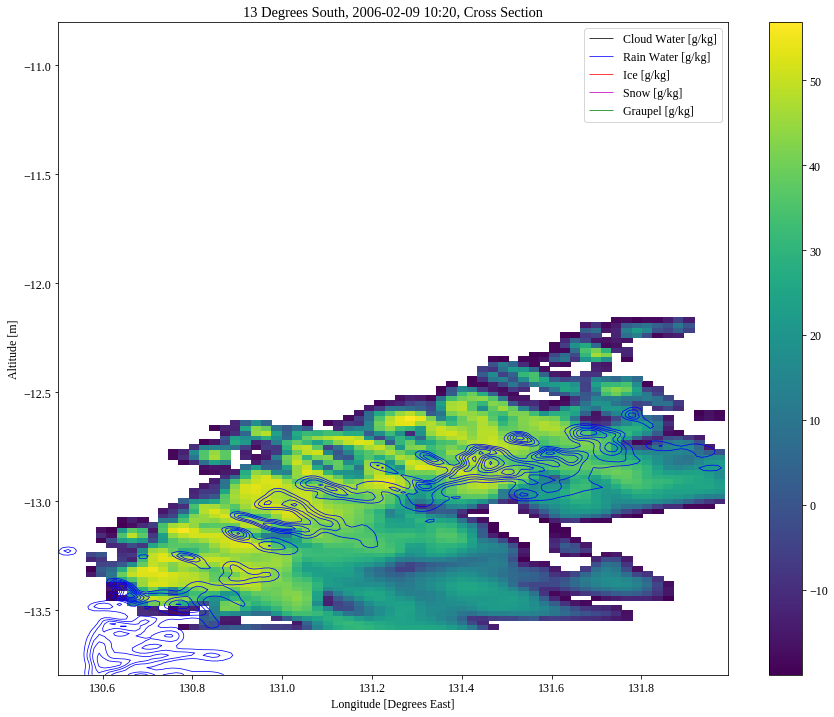

In [174]:
# Initialise fonts
rcParams.update({'font.family' : 'serif'})
rcParams.update({'font.serif': 'Liberation Serif'})
rcParams.update({'mathtext.fontset' : 'dejavuserif'})
rcParams.update({'font.size': 12})    

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1,)
# plt.contourf(W.west_east.values, W.bottom_top_stag.values, W, levels=np.arange(-16,18,2), cmap='RdBu_r')
# cbar = plt.colorbar()
# cbar.set_label('Vertical Velocity [m/s]')

cnt0 = ax.pcolor(test_sub.y, test_sub.x, test_sub.reflectivity)
cbar = plt.colorbar(cnt0)

# cnt1 = ax.contour(W.west_east.values, QCLOUD.bottom_top, QCLOUD, 
#                   colors='k', levels=[0.0001], linewidths=0.75)
# cnt2 = ax.contour(W.west_east.values, QCLOUD.bottom_top, QRAIN, 
#                   colors='b',  levels=[0.0001], linewidths=0.75)
# cnt3 = ax.contour(W.west_east.values, QICE.bottom_top, QICE, 
#                   colors='r',levels=[0.0001], linewidths=0.75)
# cnt3 = ax.contour(W.west_east.values, QSNOW.bottom_top, QSNOW, 
#                   colors='m',levels=[0.0001], linewidths=0.75)
# cnt3 = ax.contour(W.west_east.values, QGRAUP.bottom_top, QGRAUP, 
#                   colors='m',levels=[0.0001], linewidths=0.75)

# cnt1 = ax.contour(W.west_east.values, QCLOUD.south_north, QCLOUD, 
#                   colors='k', linewidths=0.75)
cnt2 = ax.contour(W.west_east.values, QCLOUD.south_north, QRAIN, 
                  colors='b', linewidths=0.75)
# cnt3 = ax.contour(W.west_east.values, QICE.bottom_top, QICE, 
#                   colors='r', linewidths=0.75)
# cnt4 = ax.contour(W.west_east.values, QSNOW.south_north, QSNOW, 
#                   colors='m', linewidths=0.75)
# cnt5 = ax.contour(W.west_east.values, QGRAUP.south_north, QGRAUP, 
#                   colors='g', linewidths=0.75)

h1,_ = cnt1.legend_elements()
# h2,_ = cnt2.legend_elements()
h3,_ = cnt3.legend_elements()
h4,_ = cnt4.legend_elements()
h5,_ = cnt5.legend_elements()

plt.xlabel('Longitude [Degrees East]')
plt.ylabel('Altitude [m]')
plt.title('13 Degrees South, 2006-02-09 10:20, Cross Section')

plt.legend([h1[0], h2[0], h3[0], h4[0], h5[0]], 
           ['Cloud Water [g/kg]', 'Rain Water [g/kg]', 'Ice [g/kg]', 
            'Snow [g/kg]', 'Graupel [g/kg]'])
# plt.contour(W.west_east.values, QICE.bottom_top, QGRAUP, colors='m', levels = [0.0001], linewidths=0.75)
plt.savefig('/g/data/w40/esh563/CPOL_analysis/figures/caine/wrf_example_test.png', dpi=200)